In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
import statsmodels.api as sm

In [4]:
import requests
import json
from datetime import datetime
import time

In [5]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [117]:
file = 'CSV_for_EDA.csv'

In [118]:
df_daily = pd.read_csv(file, index_col='date', parse_dates=True)

In [119]:
df_daily.head()
df_daily.tail()

,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month,closed,ppa
date,,,,,,,,,,,,,,,,
2017-01-02,12814.84,173.0,0,35.59,0.93,0.0243,03:00PM,0.74,rain,1027.76,rain,39.12,0,1,0,74.074220
2017-01-03,12442.11,184.0,0,41.72,0.95,0.0919,05:00PM,0.70,rain,999.38,rain,43.06,1,1,0,67.620163
2017-01-04,11877.64,176.0,0,35.07,0.37,0.0180,12:00AM,0.00,rain,1003.24,clear-night,41.16,2,1,0,67.486591
2017-01-05,14057.79,190.0,0,26.44,0.49,0.0000,05:01AM,0.00,none,1014.93,cloudy,31.49,3,1,0,73.988368
2017-01-06,14531.97,194.0,0,24.24,0.49,0.0023,12:00PM,0.00,snow,1023.22,partly-cloudy-night,29.02,4,1,0,74.907062


,sales,covers,outside,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_prob,precip_type,pressure,summary,temperature,day_of_week,month,closed,ppa
date,,,,,,,,,,,,,,,,
2019-06-12,18032.37,246.0,1,65.80,0.56,0.0000,05:01AM,0.00,none,1020.48,partly-cloudy-day,65.80,2,6,0,73.302317
2019-06-13,15209.75,207.0,1,64.06,0.76,0.1721,10:00AM,0.00,rain,1007.55,cloudy,64.06,3,6,0,73.477053
2019-06-14,19688.38,292.0,1,73.42,0.34,0.0191,12:00AM,0.00,rain,1014.65,clear-day,73.42,4,6,0,67.425959
2019-06-15,21059.31,306.0,1,76.24,0.45,0.0054,12:00AM,0.00,rain,1015.18,partly-cloudy-day,76.24,5,6,0,68.821275
2019-06-16,17805.29,242.0,1,75.12,0.79,0.0087,08:00PM,0.15,rain,1009.58,partly-cloudy-day,74.29,6,6,0,73.575579


In [120]:
df_daily[['sales', 'covers', 'ppa']].corr()

,sales,covers,ppa
sales,1.000000,0.895819,0.426422
covers,0.895819,1.000000,0.083227
ppa,0.426422,0.083227,1.000000


In [121]:
df_daily[df_daily['outside'] == 1][['sales', 'covers', 'ppa']].corr()

,sales,covers,ppa
sales,1.000000,0.821097,0.129294
covers,0.821097,1.000000,-0.449352
ppa,0.129294,-0.449352,1.000000


In [122]:
## IMPUTE OUTLIERS & CLOSED

z_thresh = 3

def impute_outliers(df, *col):
    
    for c in col:
        
        print('------ ', c, '------', '\n')
        
        for d in df['day_of_week'].unique():
            print('Day ', d)
            
            daily_median = np.median(df[df['day_of_week'] == d][c])
            print('Daily Median ->', daily_median)
            
            daily_mean = np.mean(df[df['day_of_week'] == d][c])
            print('Daily Mean ->', daily_mean)
            
            daily_std = np.std(df[df['day_of_week'] ==d ][c])
            print('Daily STD ->', daily_std)
            
            df['temp_col'] = np.where((df['day_of_week'] == d) & ((np.abs(df[c] - daily_mean)) > (daily_std * z_thresh)), 1, 0)
            print('Number of Outliers Imputed -> Day ', d, ': ', sum(df['temp_col']), '\n')
            
            df[c] = np.where(df['temp_col'] == 1, daily_median, df[c])
            df = df.drop(['temp_col'], axis=1)
        
    df.drop(['closed'], axis=1)
        
    return df

### CREATE DAILY SALES DATAFRAME

In [123]:
df_daily = impute_outliers(df_daily, 'sales', 'covers')
df_daily['ppa'] = df_daily['sales'] / df_daily['covers']

------  sales ------ 

Day  0
Daily Median -> 14424.9375
Daily Mean -> 14644.535820312494
Daily STD -> 3219.570548502923
Number of Outliers Imputed -> Day  0 :  3 

Day  1
Daily Median -> 14127.595000000001
Daily Mean -> 14606.326406249998
Daily STD -> 3102.566080617968
Number of Outliers Imputed -> Day  1 :  3 

Day  2
Daily Median -> 15520.3475
Daily Mean -> 15440.529999999999
Daily STD -> 2267.3102382351326
Number of Outliers Imputed -> Day  2 :  0 

Day  3
Daily Median -> 15456.89
Daily Mean -> 15842.237187499999
Daily STD -> 2975.241753212548
Number of Outliers Imputed -> Day  3 :  2 

Day  4
Daily Median -> 17383.935
Daily Mean -> 17876.931484375
Daily STD -> 2843.0896597809347
Number of Outliers Imputed -> Day  4 :  0 

Day  5
Daily Median -> 18987.5275
Daily Mean -> 19086.550859374995
Daily STD -> 2751.863813549196
Number of Outliers Imputed -> Day  5 :  0 

Day  6
Daily Median -> 15407.93
Daily Mean -> 15805.828515624995
Daily STD -> 3890.2537991016916
Number of Outliers Imput

In [124]:
df_daily = df_daily[['sales', 'covers', 'ppa', 'day_of_week', 'month']]

## TRAIN TEST SPLIT

In [125]:
def train_test_split(df):
    
    # Test / Train / Split
    train_date_start = '2017-01-01'
    train_date_end = '2018-12-31'
    
    X_train = df[pd.to_datetime(train_date_start) : train_date_end]
    X_test = df[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]

    return X_train, X_test

X_train_daily, X_test_daily = train_test_split(df_daily)

## DAILY

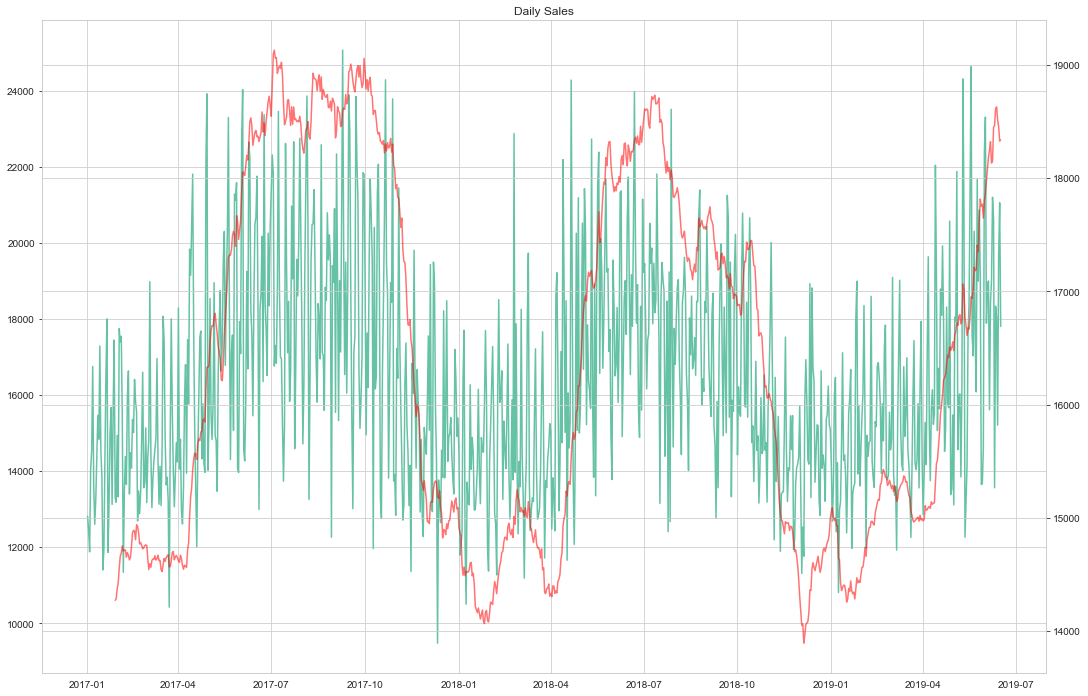

In [126]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,12))

target = 'sales'

sns.lineplot(data=df_daily[target])
ax2 = plt.twinx()
sns.lineplot(data=df_daily[target].rolling(28).mean(), color="r", alpha=0.55, ax=ax2)
plt.title('Daily Sales');

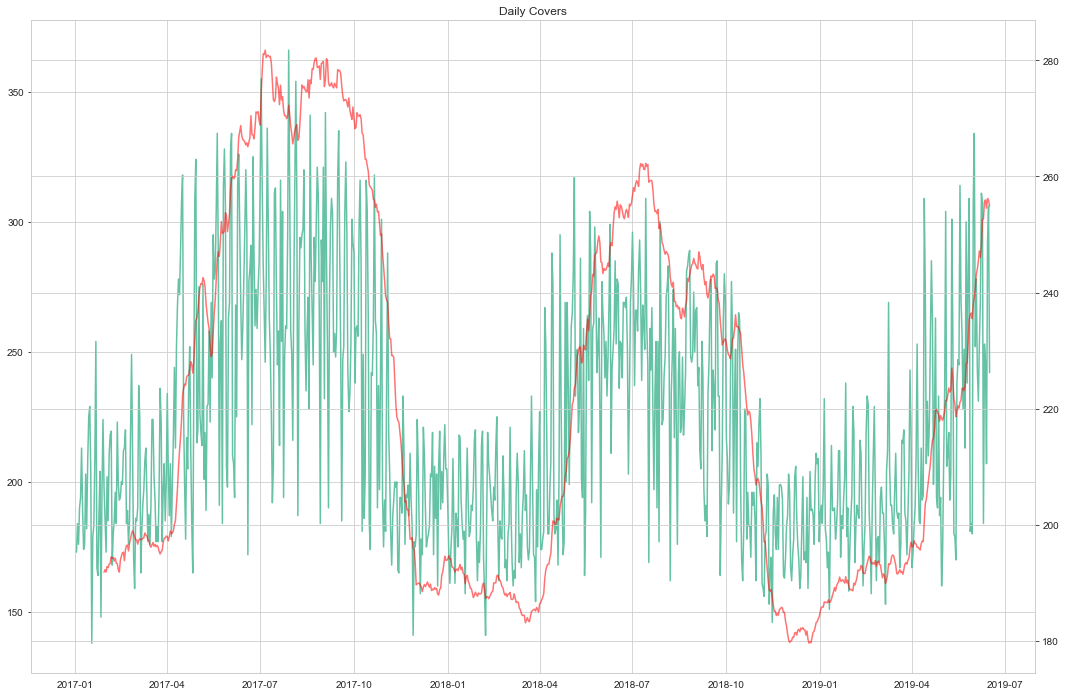

In [127]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,12))

target = 'covers'

sns.lineplot(data=df_daily[target])
ax2 = plt.twinx()
sns.lineplot(data=df_daily[target].rolling(28).mean(), color="r", alpha=0.55, ax=ax2)
plt.title('Daily Covers');

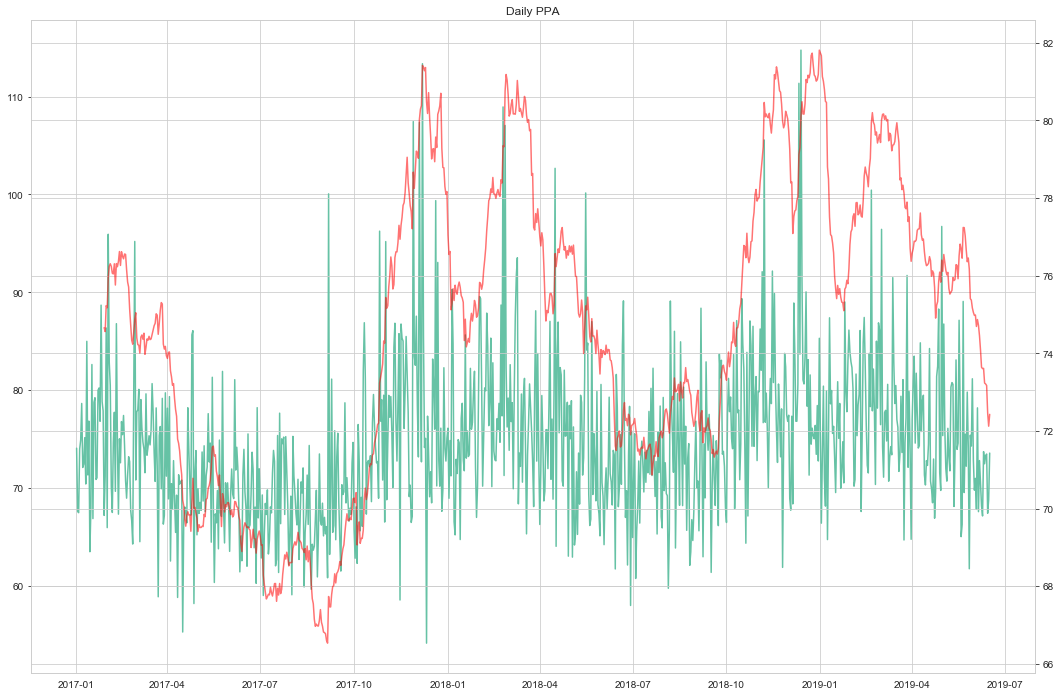

In [128]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,12))

target = 'ppa'

sns.lineplot(data=df_daily[target])
ax2 = plt.twinx()
sns.lineplot(data=df_daily[target].rolling(28).mean(), color="r", alpha=0.55, ax=ax2)
plt.title('Daily PPA');

### Seasonal Decompose - Daily

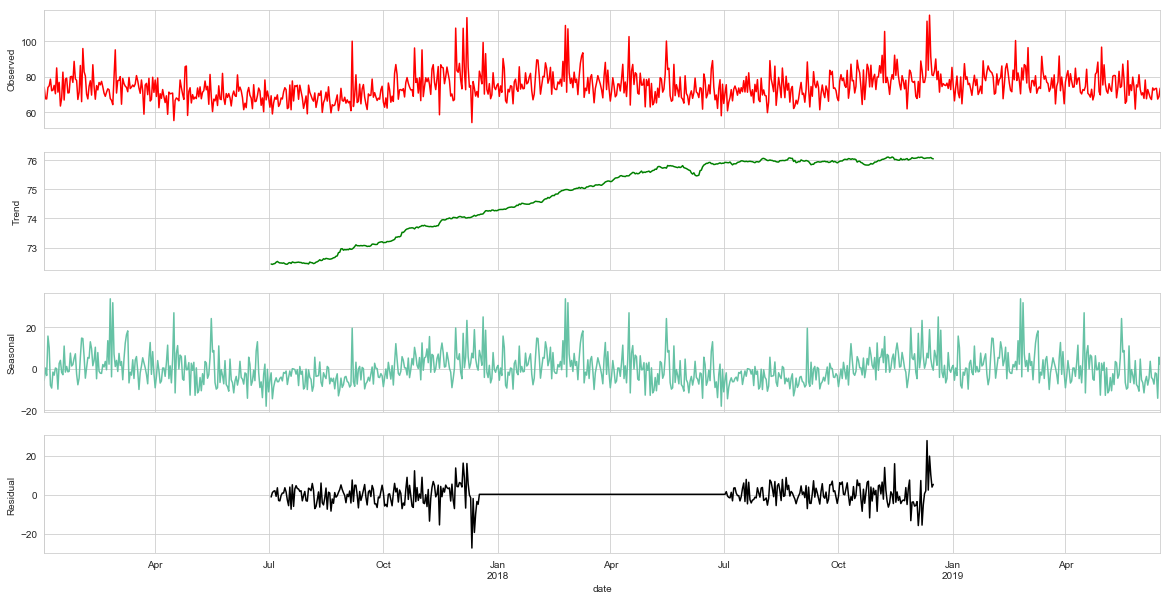

In [129]:
def seasonal_decompose_plots(df, target, freq):
    
    deco = sm.tsa.seasonal_decompose(df[target], model='additive', freq=freq)

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(20,10))
    
    deco.observed.plot(ax=axes[0], legend=False, color='r')
    axes[0].set_ylabel('Observed')

    deco.trend.plot(ax=axes[1], legend=False, color='g')
    axes[1].set_ylabel('Trend')

    deco.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')

    deco.resid.plot(ax=axes[3], legend=False, color='k')
    axes[3].set_ylabel('Residual');
    
seasonal_decompose_plots(df_daily, 'ppa', 365)

## Set Target

In [156]:
target = 'ppa'

df_daily = df[[target]]

NameError: name 'df' is not defined

In [ ]:
df_daily

### Stationarity

In [130]:
def test_stationarity(df, target, regression):
    
    res = sm.tsa.adfuller(df[target],regression=regression)
    print('p-value -> regression -> {}: {}'.format(regression, res[1]))

test_stationarity(df_daily, 'ppa', regression='c')
test_stationarity(df_daily, 'ppa', regression='ct')
test_stationarity(df_daily, 'ppa', regression='ctt')

p-value -> regression -> c: 0.04223383078695575
p-value -> regression -> ct: 0.0925314612448409
p-value -> regression -> ctt: 0.21161647982463155


### Stationarity - Differenced

In [131]:
def test_stationarity(df, target, regression):
    
    res = sm.tsa.adfuller(df[target].diff(7).dropna(),regression=regression)
    print('p-value -> regression -> {}: {}'.format(regression, res[1]))

test_stationarity(df_daily, 'ppa', regression='c')
test_stationarity(df_daily, 'ppa', regression='ct')
test_stationarity(df_daily, 'ppa', regression='ctt')

p-value -> regression -> c: 1.6673365239671092e-16
p-value -> regression -> ct: 1.507722142311389e-14
p-value -> regression -> ctt: 2.3337510338532503e-14


### Auto + Partial Correlation

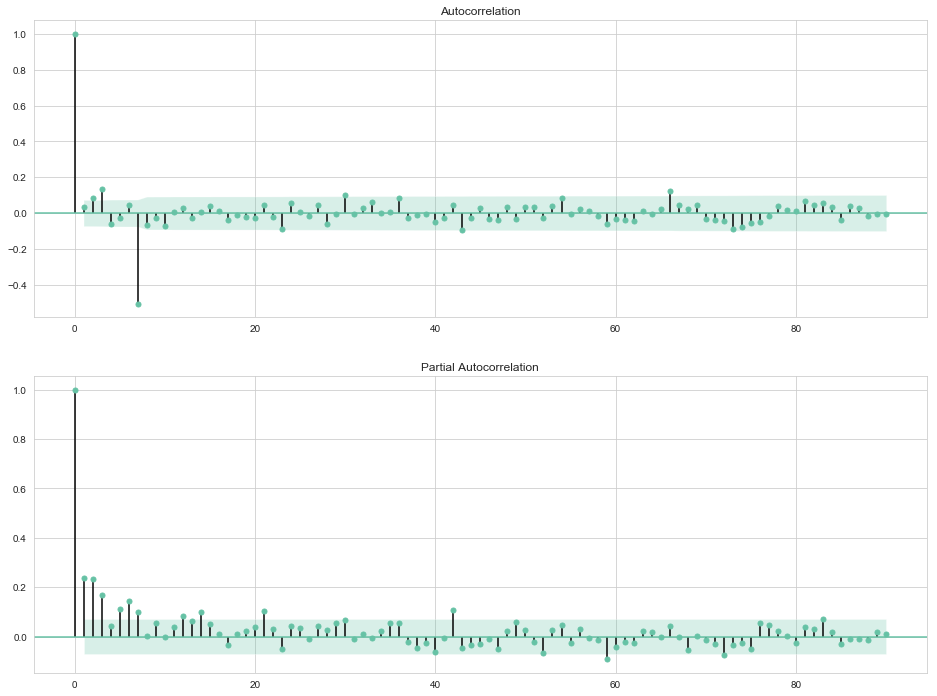

In [132]:
def auto_correlation_plot(df, target, lags):
    
    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(211)

    lags = lags

    #plot the ACF
    fig = sm.graphics.tsa.plot_acf(df[target].diff(7).dropna(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)

    #plot the PACF
    fig = sm.graphics.tsa.plot_pacf(df[target].dropna(), lags=lags, ax=ax2)
    
auto_correlation_plot(X_train_daily, 'ppa', 90)

### ARIMA Model Parameter Search

In [26]:
def find_arima_orders(df, target, trend):
    
    resDiff = sm.tsa.arma_order_select_ic(df[target].diff(7).dropna(), max_ar=7, max_ma=7, ic='aic', trend=trend)
    print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')
    
find_arima_orders(X_train_daily, 'ppa', trend='c')

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packa

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packag

ARMA(p,q) = (3, 7) is the best.


In [159]:
def arima_model(df, target, p, d, q, P, D, Q, m):

    arima = sm.tsa.statespace.SARIMAX(df[target],order=(p,d,q),seasonal_order=(P,D,Q,m),
                                 enforce_stationarity=False, enforce_invertibility=False,)

    res = arima.fit()
    print(res.summary())
    
    return res

res = arima_model(X_train_daily, 'ppa', p=3, d=0, q=7, P=0, D=1, Q=1, m=7)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                               ppa   No. Observations:                  729
Model:             SARIMAX(3, 0, 7)x(0, 1, 1, 7)   Log Likelihood               -2404.227
Date:                           Mon, 17 Jun 2019   AIC                           4832.454
Time:                                   20:00:07   BIC                           4887.187
Sample:                               01-02-2017   HQIC                          4853.602
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1600      0.147      1.091      0.275      -0.127       0.447
ar.L2          0.0370      0.162      0.228

In [162]:
test_start = '12-31-2017'
test_end = '06-16-2019'

pred = res.predict(test_start,test_end)[1:]

print('ARIMA model RMSE: {}'.format(np.sqrt(mean_squared_error(X_test_daily['ppa'], pred))))

ValueError: Found input variables with inconsistent numbers of samples: [167, 532]


 Mean Absolute Error:  5.18432341261367


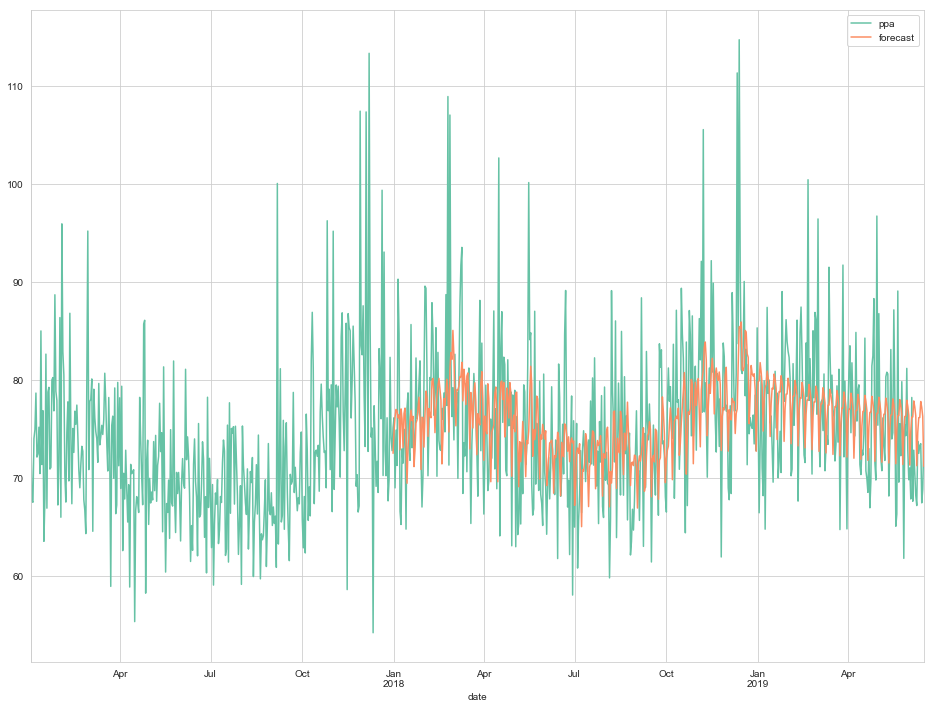

In [163]:
def sarimax_forecast(df, model, target, start_period, forecast_periods):
    
    df['forecast'] = model.predict(test_start, test_end, dynamic=False)
    df[[target, 'forecast']].plot(figsize=(16,12))
    
    print('\n', 'Mean Absolute Error: ', np.abs(df[start_period:]['ppa']- df[start_period:]['forecast']).sum()/len(df[start_period:]))
    
    return df

df_forecast = sarimax_forecast(df_daily, res, 'ppa', test_start, test_end)

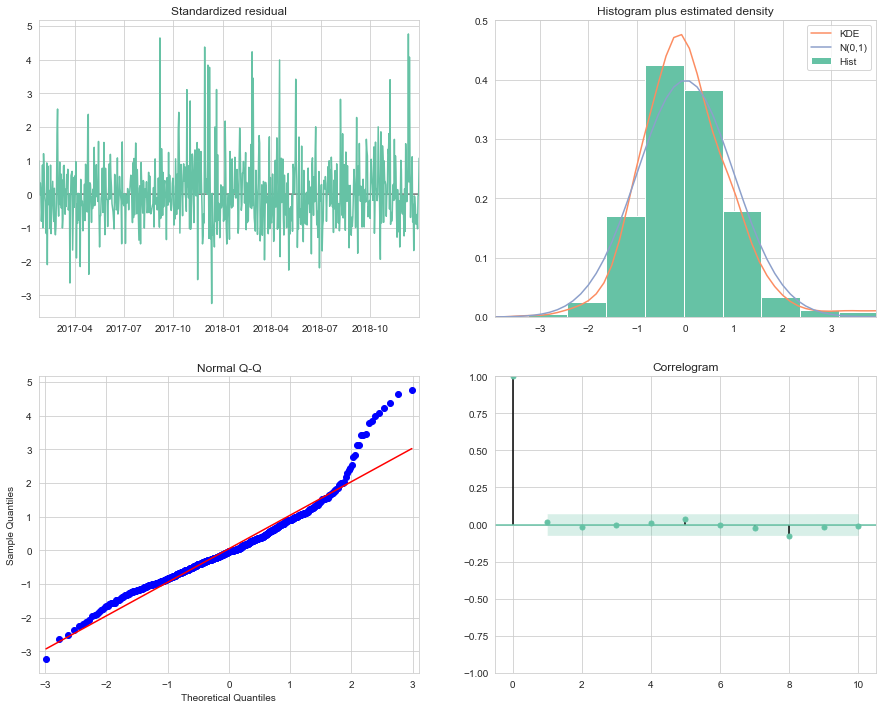

In [135]:
res.plot_diagnostics(figsize=(15, 12));

In [139]:
df_forecast.tail()

,sales,covers,ppa,day_of_week,month,forecast
date,,,,,,
2019-06-12,18032.37,246.0,73.302317,2,6,76.013940
2019-06-13,15209.75,207.0,73.477053,3,6,77.612153
2019-06-14,19688.38,292.0,67.425959,4,6,76.999057
2019-06-15,21059.31,306.0,68.821275,5,6,76.147161
2019-06-16,17805.29,242.0,73.575579,6,6,70.986051


In [144]:
pred = res.get_prediction(start=pd.to_datetime('2019-06-17'), dynamic=False)
pred_conf = pred.conf_int()